## Melting point predictor for carbon compounds with no benzene substructure

In this notebook the process to evaluate different machine learning models on our data is explained

In [1]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex 
from rdkit.Chem import Descriptors
from IPython.display import display
# sklearn and models for model training 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# For fine tuning
from sklearn.model_selection import GridSearchCV
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex
from rdkit.Chem import Descriptors

# Import the module
import Functions.datapreprocess as dp
from Functions.datapreprocess import (
    canonical_smiles,
    canonical_smiles_column,
    generate_mordred_descriptors,
    generate_mordred_dataframe,
    generate_mordred_columns,
    remove_low_variance_features,
    remove_highly_correlated,
    handle_nan_values
)

NameError: name 'GetMorganFingerprintAsBitVect' is not defined

In [5]:
path_data = Path("../Data/cleaned_data.xlsx")
dataset = pd.read_excel(path_data)
inital_shape = dataset.shape
print(inital_shape)

(19945, 2)


## Restrict the model to less data

As the dataset is very large (nearly 20k data). We'll first restrict our model to a certain type of molecule. This will enable us to familiarize ourselves with machine learning methods without using up too much computational speed. Initially, we'll restrict the analysis to compounds containing only carbon and hydrogen atoms.

In [6]:
# Convert every smiles in canonical smiles
carbon_dataset = dp.canonical_smiles_column(df = dataset, smiles_column="smiles")
carbon_dataset.shape

Removed 0 rows with invalid SMILES strings.


(19945, 3)

In [7]:
# Define a function to check if a SMILES contains only carbon
def contains_carbon(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetSymbol() != "C":
                return False
        return True
    except:
        return False

In [8]:
# Apply the function to the dataset
carbon_dataset = dataset[dataset['smiles'].apply(contains_carbon)]
carbon_dataset.shape

(866, 2)

## Data exploring
We see that we end up with 866 rows, one for each molecule, we have a 2 columns : "smiles" and "mpC" for the melting point in degree celsius. Now we're going to explore our data.

We know from chemistry that for alkanes, the number of carbons is an important factor in the melting point. Let's plot these 2 values for every compounds and see if we observe this trend.

In [66]:
# Counting the number of carbon for every molecule and add this number in a new column

# Function to count the number of carbon atoms in a molecule
def count_carbon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)
    return carbon_count

In [9]:
# Add a new column 'carbon_count' to the DataFrame
carbon_dataset.loc[:, 'carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)


/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_38378/3724280406.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset.loc[:, 'carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)


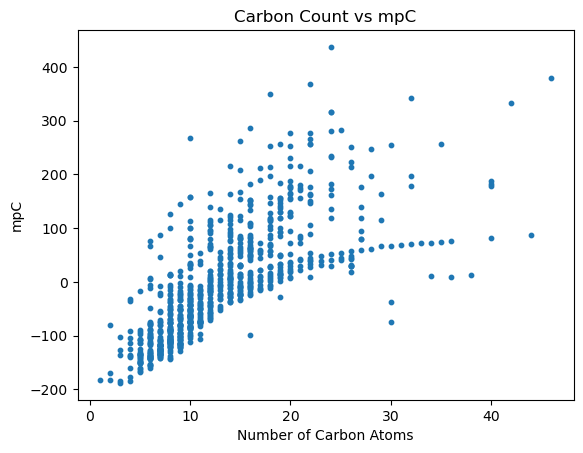

In [10]:
# Plot mpC vs Carbon_count

plt.scatter(carbon_dataset['carbon_count'], carbon_dataset['mpC'], s=10)
plt.xlabel('Number of Carbon Atoms')
plt.ylabel('mpC')
plt.title('Carbon Count vs mpC')
plt.show()

The expected trend is observed, with a curve emerging in our scatterplot. 
Some molecules seem to have a much higher melting point than others. We know that the presence of benzene can affect the melting point through pi-stacking interactions. Displaying the 20 molecules with the highest melting point to see if that is the case. 

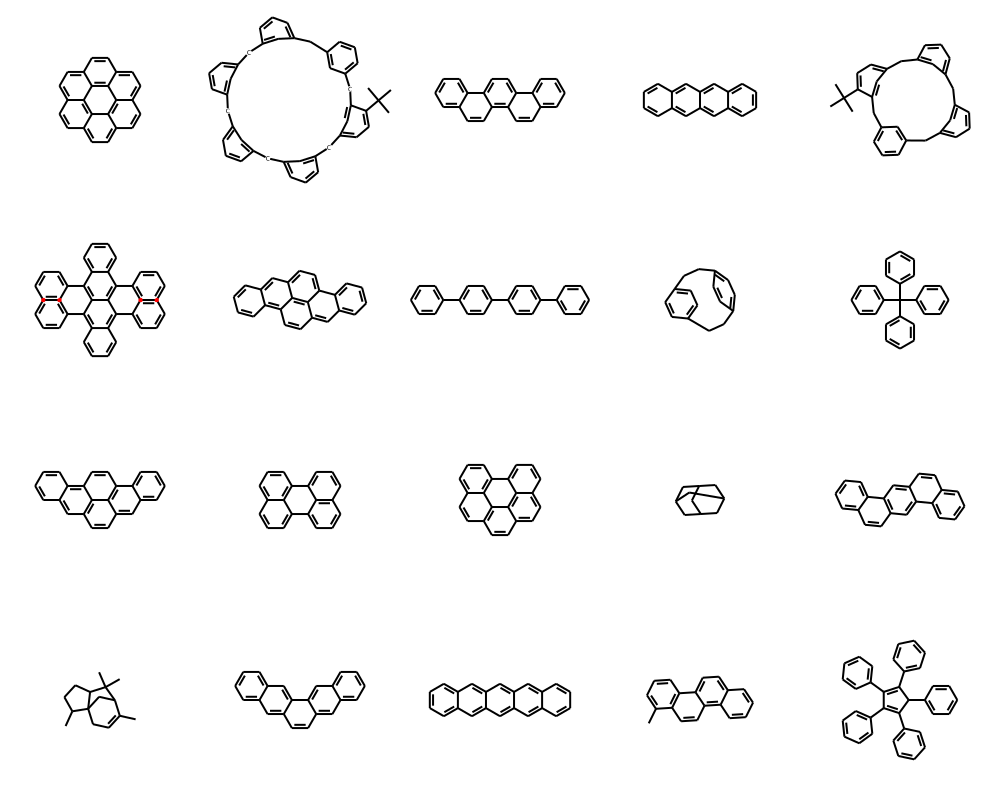

In [11]:
# See wich molecules have a high melting point
number_of_molecules_to_display = 20

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = carbon_dataset.sort_values(by='mpC', ascending=False)

# Get the top molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Draw the molecules in a grid
imge = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
display(imge)

Indeed, we can see that most of the compounds with the highest melting points have benzene as a substructure. We also note that all molecules with high melting points are highly symmetrical. \

**Let's see if the plot is different without compounds having benzene as substructure :**

In [12]:
# Function to check for benzene substructure
def has_benzene_substructure(smiles):
    mol = Chem.MolFromSmiles(smiles)
    benzene_substructure = Chem.MolFromSmarts('c1ccccc1')
    return mol.HasSubstructMatch(benzene_substructure)

# Add a new column 'has_benzene_sub' to the DataFrame
carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)

# Selecting only molecules without benzene substructure
dataset_no_benzene = carbon_dataset[carbon_dataset['has_benzene_sub'] != True]

/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_38378/3910885534.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)


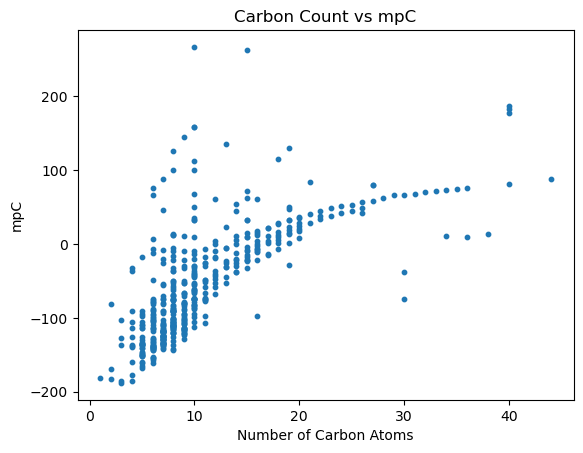

In [13]:
# See the plot without benzene 

plt.scatter(dataset_no_benzene['carbon_count'], dataset_no_benzene['mpC'], s=10)
plt.xlabel('Number of Carbon Atoms')
plt.ylabel('mpC')
plt.title('Carbon Count vs mpC')
plt.show()

The plot is different, with maximum values at around 200°C, compared with around 400°C before when including the benzene substructure. We also observe that 2 molecules are very different from the others, with few carbons but a high melting point. Let's display these molecules with their melting point :

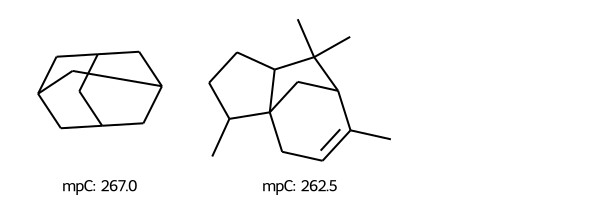

In [14]:
# Number of molecules to display
number_of_molecules_to_display = 2

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = dataset_no_benzene.sort_values(by='mpC', ascending=False)

# Get the top molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Create legend text with melting point values
legend_texts = [f"mpC: {mp}" for mp in top_molecules['mpC']]

# Draw the molecules in a grid with legend
img = Draw.MolsToGridImage(mols, legends=legend_texts, subImgSize=(200, 200))
display(img)

## Model training

In order to create a model, we need features for each molecules that the model will use to predict the melting point. We will use the "mordred descritptors", we first need to calculate all mordred descriptors for all molecules from the dataset_no_benzene. As this takes a long time to run, it has already been done and the result saved with :
\
\
*df_combined.to_excel('non_benzene_descriptors.xlsx', index=False)*
\
\
the name of the dataset is then "non_benzene_descriptors.xlsx".

In [17]:

"""
# Generate Mordred descriptors for non-benzene molecules using generate_mordred_columns

non_benz_desc = generate_mordred_columns(dataset_no_benzene, "smiles", ignore_3D=False)
non_benz_desc.shape

The mordred descriptors calculation take some time and has already been done, results are in the "non_benz_mordred.csv" file, to load it :
"""
non_benz_desc = pd.read_csv("non_benz_mordred.csv")
non_benz_desc.shape


(486, 1829)

### Cleaning the features
We now have our descriptors that will be used to predict the melting point. As we have not selected manually the descriptors, some of them will be irrelevant. For example, the descriptor "HBondAcceptor" is not useful as we only have carbon compounds, none of them will have Hbond abilities. Also, we may have some descriptors that describe the same thing (highly correlated descriptors), so only one of them is useful to train the model. \
Because of this, we will remove low variance descriptors, and keep only 1 descriptors if we have a set of highly correlated descriptors.

In [18]:
# Remove low variance features using the remove_low_variance_features function
non_benz_desc = remove_low_variance_features(non_benz_desc, threshold=0.05)
non_benz_desc.shape

(486, 787)

In [19]:
# Remove high correlated features using the remove_highly_correlated function
non_benz_desc = remove_highly_correlated(non_benz_desc, excluded_cols=['mpC', "smiles"], threshold=0.95)
non_benz_desc.shape

(486, 226)

In [20]:
# Handle NaN values using the handle_nan_values function
non_benz_desc = handle_nan_values(non_benz_desc, threshold=80)
non_benz_desc.shape

(486, 196)

Random Forest Regressor - MSE: 1036.22, R2: 0.84


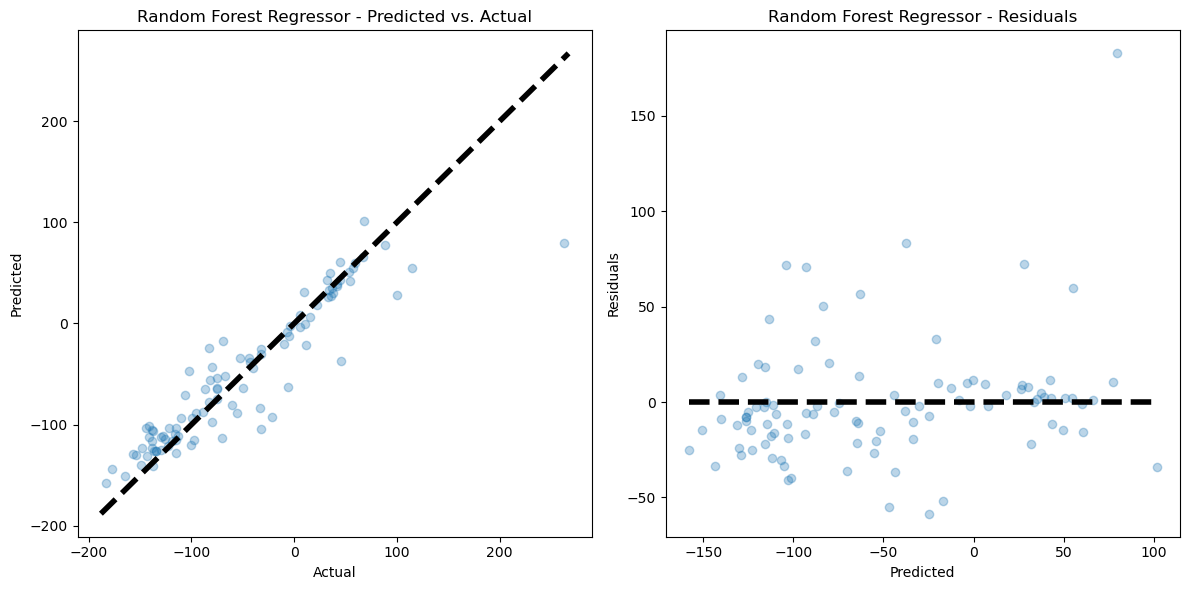

Gradient Boosting Regressor - MSE: 1057.05, R2: 0.84


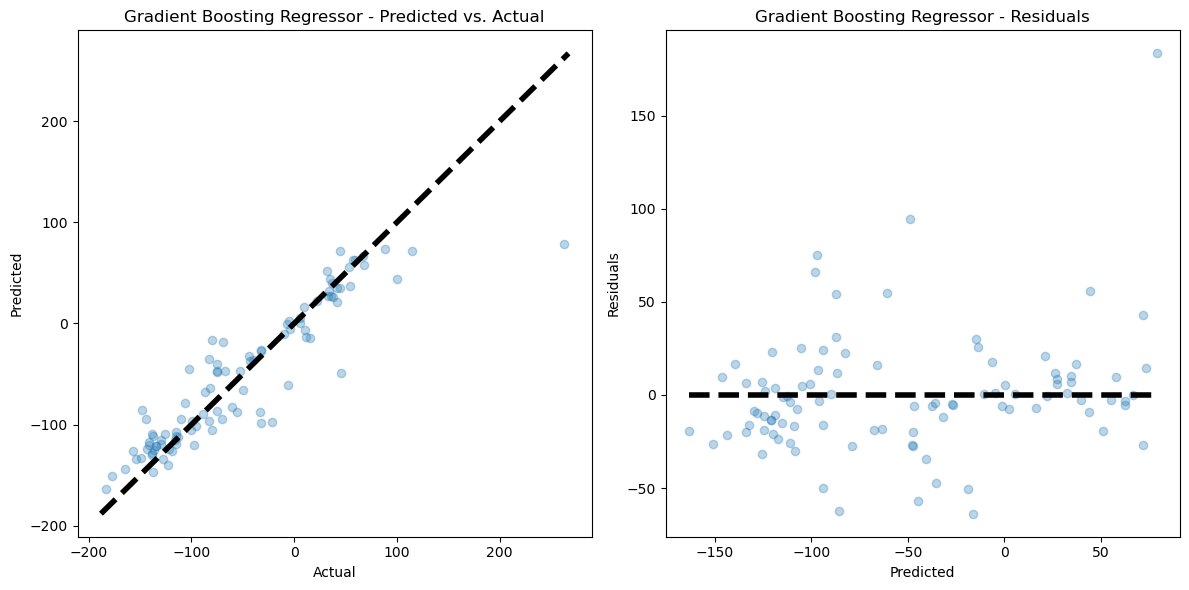

K Neighbors Regressor - MSE: 1945.53, R2: 0.70


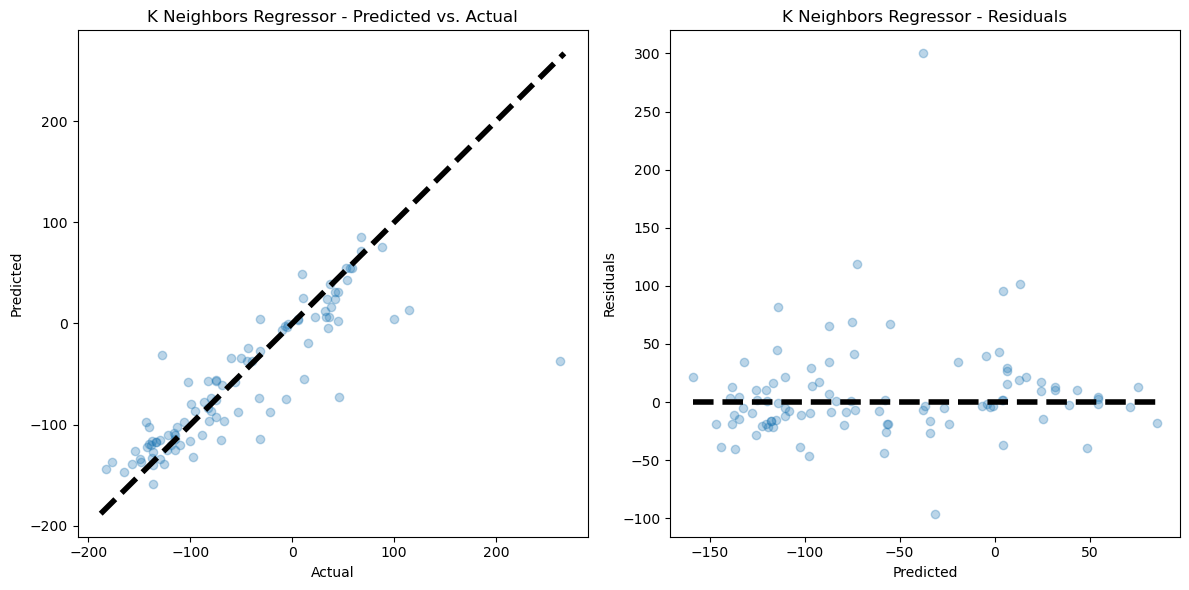

Decision Tree Regressor - MSE: 1546.51, R2: 0.77


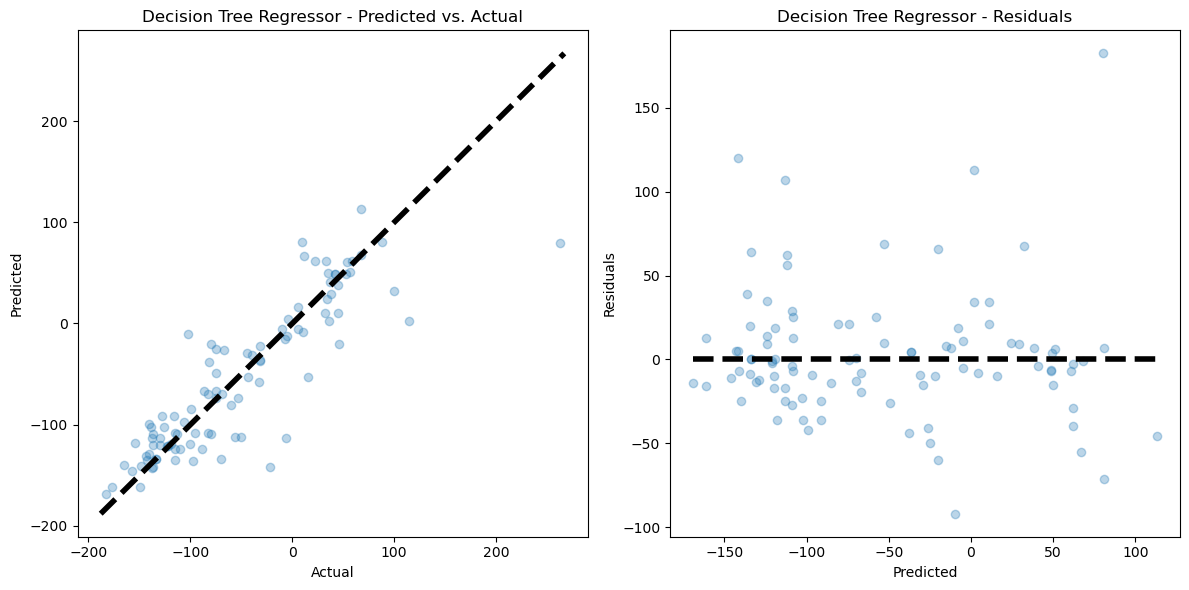

XGBoost - MSE: 1445.05, R2: 0.78


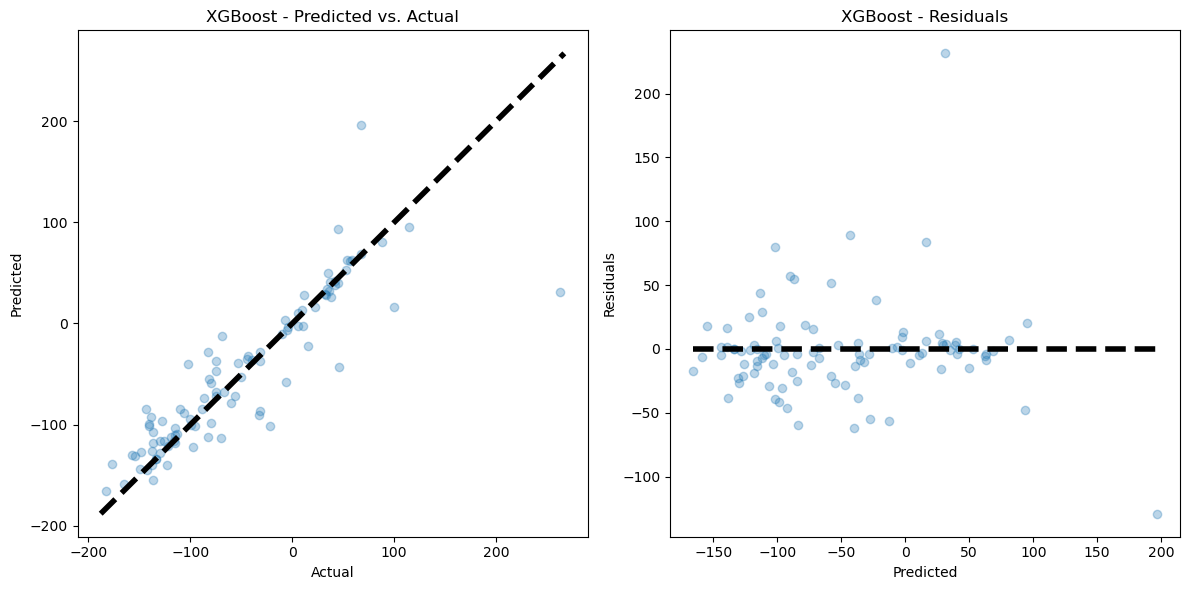

LightGBM - MSE: 920.86, R2: 0.86


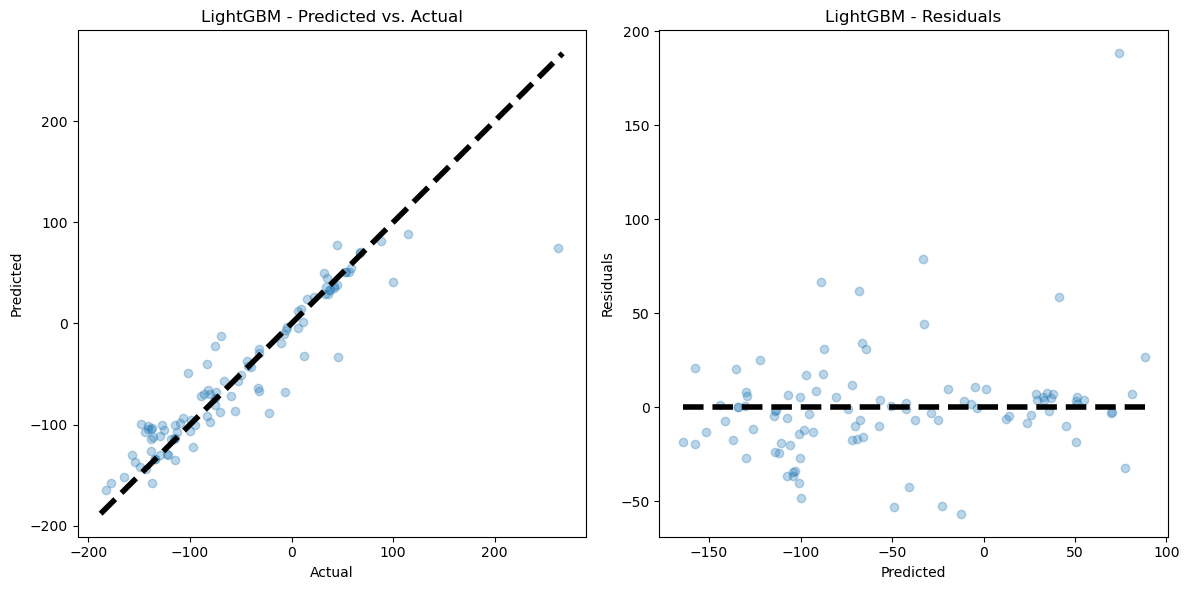

In [22]:
# Separating the features and the target variable
X = non_benz_desc.drop(columns=['smiles', 'mpC'])  
y = non_benz_desc['mpC']  

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary of models for ease of iteration
models = {
    'Random Forest Regressor': RandomForestRegressor(random_state=123),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=123),
    'K Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=123),
    'XGBoost': XGBRegressor(random_state=123),
    'LightGBM': LGBMRegressor(random_state=123)
}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} - Predicted vs. Actual')
    
# Plotting Residuals
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residuals')
    
    plt.tight_layout()
    plt.show()

Without any hyperparameter tunning the best performing models are :


- RandomForest
- Gradient Boosting
- LightGBM

Those 3 models are selected for hyperparameter tunning. 
As a grid search can be very demanding in terms of computing power. The following code has been executed in google colab and the best hyperparameters found are reported.

### Hyperparameters tunning for RandomForest

In [23]:
"""
# Define the model
rf = RandomForestRegressor(random_state=123)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [50, 100],  
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']  
}

# Setup and perform the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Extract best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_est

As hyperparameter tunning takes time, it has already been done results are : 

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

After tuning RandomForestRegressor - MSE: 1119.80, R2: 0.78


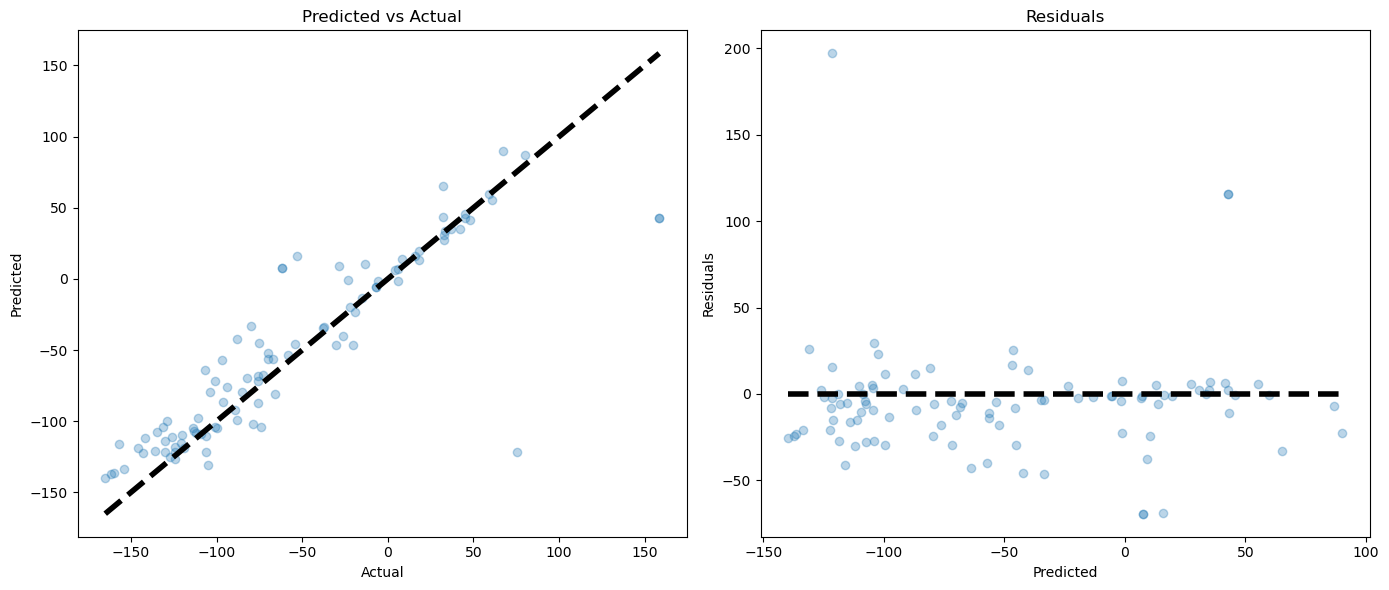

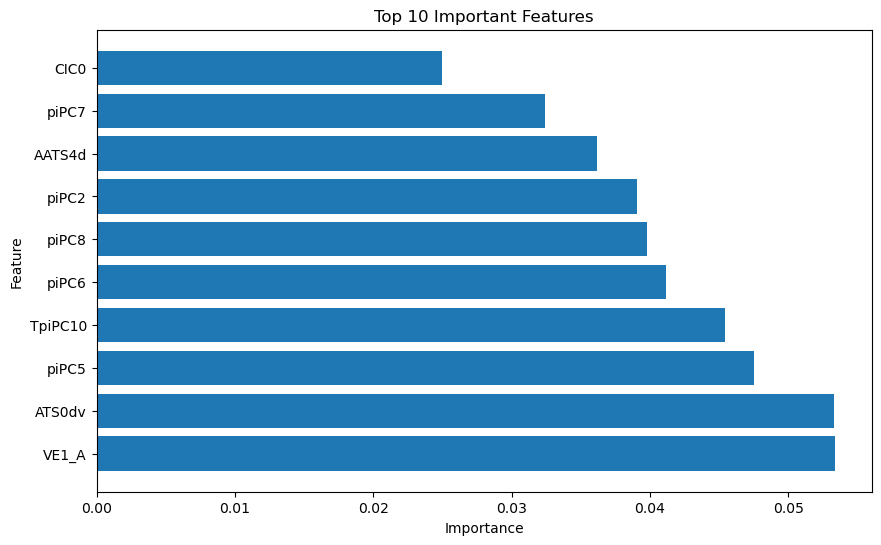

In [29]:
# visualize result for the best random forest model

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the model with the best parameters
rf_best = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

# Fit the model
rf_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning RandomForestRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')

# Plotting Residuals
residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = rf_best.feature_importances_
features = np.array(X_train.columns)
df_feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
df_sorted = df_feature_importances.sort_values('importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.show()

### Hyperparameters tunning for GradientBoosting

In [25]:
"""
# Define the model
gb = GradientBoostingRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_gb = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_gb.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3

As hyperparameter tunning takes time, it has already been done results are : 

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

After tuning GradientBoostingRegressor - MSE: 1102.34, R2: 0.79


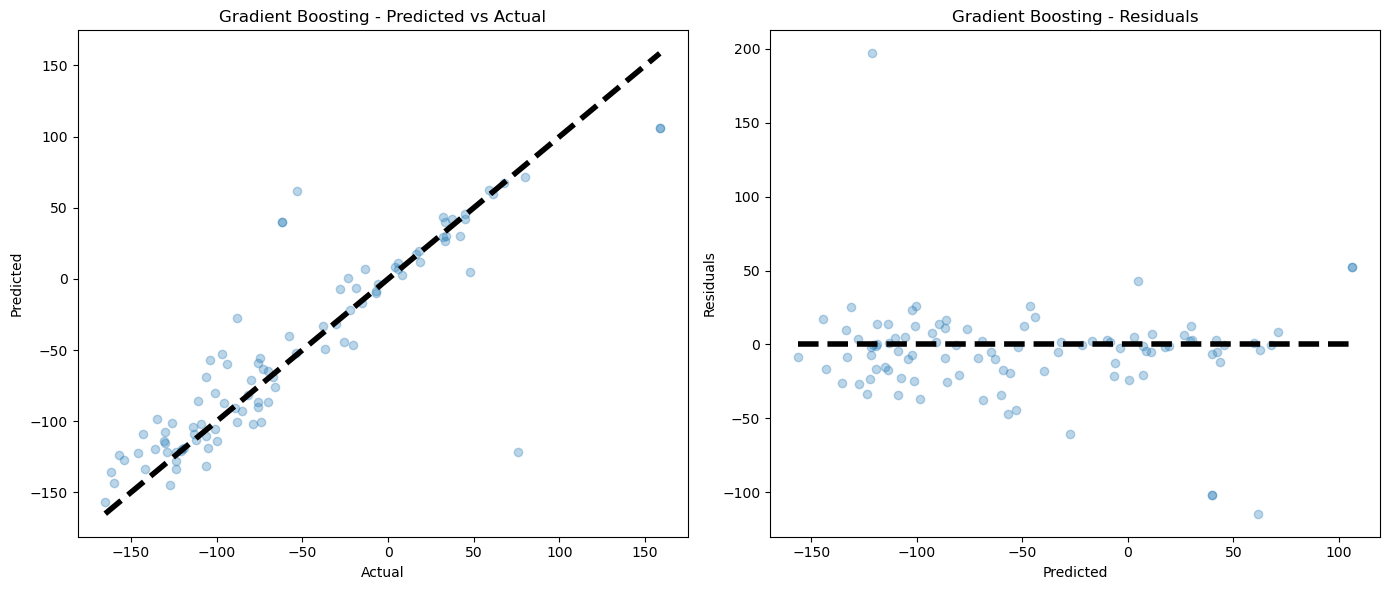

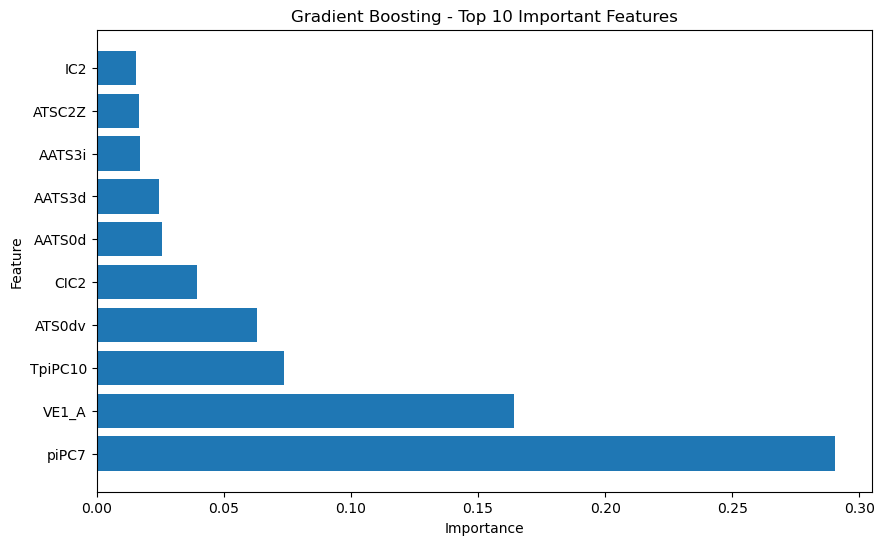

In [31]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Creating the model with the best parameters
gb_best = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200)

# Fitting the model
gb_best.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_best.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
print(f"After tuning GradientBoostingRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting - Predicted vs Actual')

# Plotting Residuals
residuals_gb = y_test - y_pred_gb

plt.subplot(1, 2, 2)

plt.scatter(y_pred_gb, residuals_gb, alpha=0.3)
plt.plot([y_pred_gb.min(), y_pred_gb.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting - Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances_gb = gb_best.feature_importances_
df_feature_importances_gb = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_gb})
df_sorted_gb = df_feature_importances_gb.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_gb['feature'], df_sorted_gb['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting - Top 10 Important Features')
plt.show()

In [40]:
"""
# Define the model
lgbm = LGBMRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 40],
    'min_child_weight': [0.001, 0.01],
    'subsample': [0.5, 0.7, 1.0],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_lgbm = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_lgbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

'\n# Define the model\nlgbm = LGBMRegressor(random_state=42)\n\n# Define the parameters grid to search\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'learning_rate\': [0.01, 0.1],\n    \'max_depth\': [3, 5, 7],\n    \'num_leaves\': [31, 63],\n    \'min_child_samples\': [20, 40],\n    \'min_child_weight\': [0.001, 0.01],\n    \'subsample\': [0.5, 0.7, 1.0],\n}\n\n# Setup the grid search\ngrid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\n\n# Perform the grid search\ngrid_search.fit(X_train_scaled, y_train)\n\n# Best parameters\nprint("Best parameters:", grid_search.best_params_)\n\n# Best model\nbest_lgbm = grid_search.best_estimator_\n\n# Predictions and evaluation\ny_pred = best_lgbm.predict(X_test)\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\nprint(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")\n'

As hyperparameter tunning takes time, it has already been done. Results are : 

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.5}

After tuning LGBMRegressor - MSE: 993.90, R2: 0.81


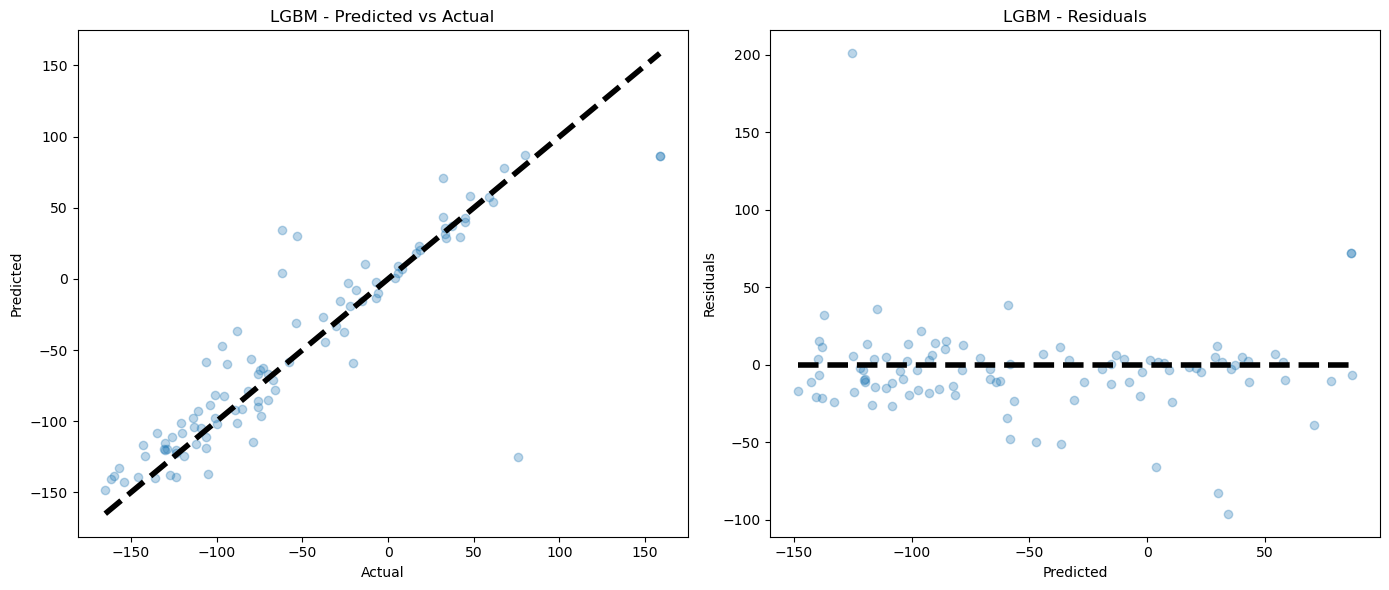

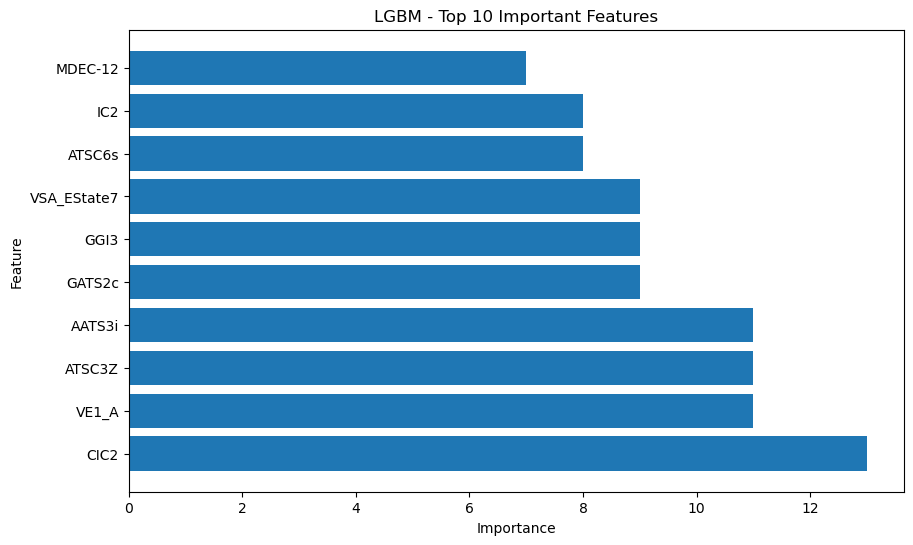

In [41]:
# Splitting the dataset into training and testing setX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating the model with the best parameters
lgbm_best = LGBMRegressor(learning_rate = 0.1, max_depth= 3, min_child_samples= 20, min_child_weight=0.001, n_estimators= 100, num_leaves=31, subsample = 0.5)

# Fitting the model
lgbm_best.fit(X_train_scaled, y_train)

# Predictions
y_pred_lgbm = lgbm_best.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_lgbm)
r2 = r2_score(y_test, y_pred_lgbm)
print(f"After tuning LGBMRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lgbm, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LGBM - Predicted vs Actual')

# Plotting Residuals
residuals_lgbm = y_test - y_pred_lgbm

plt.subplot(1, 2, 2)
plt.scatter(y_pred_lgbm, residuals_lgbm, alpha=0.3)
plt.plot([y_pred_lgbm.min(), y_pred_lgbm.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('LGBM - Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances_lgbm = lgbm_best.feature_importances_
df_feature_importances_lgbm = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_lgbm})
df_sorted_lgbm = df_feature_importances_lgbm.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_lgbm['feature'], df_sorted_lgbm['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('LGBM - Top 10 Important Features')
plt.show()

## K-Fold validation on each model

In [47]:
# K-Fold Cross Validation for the 3 models

from sklearn.model_selection import cross_val_score

# Define the models
models = {
    'Random Forest': rf_best,
    'Gradient Boosting': gb_best,
    'LightGBM': lgbm_best
}

# Perform K-Fold Cross Validation
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{name} - RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

Random Forest - RMSE: 33.82 (+/- 8.58)
Gradient Boosting - RMSE: 32.43 (+/- 7.60)
LightGBM - RMSE: 33.25 (+/- 8.27)


## Trying with a multimodel

Mean prediction - MSE: 1012.19, R2: 0.80


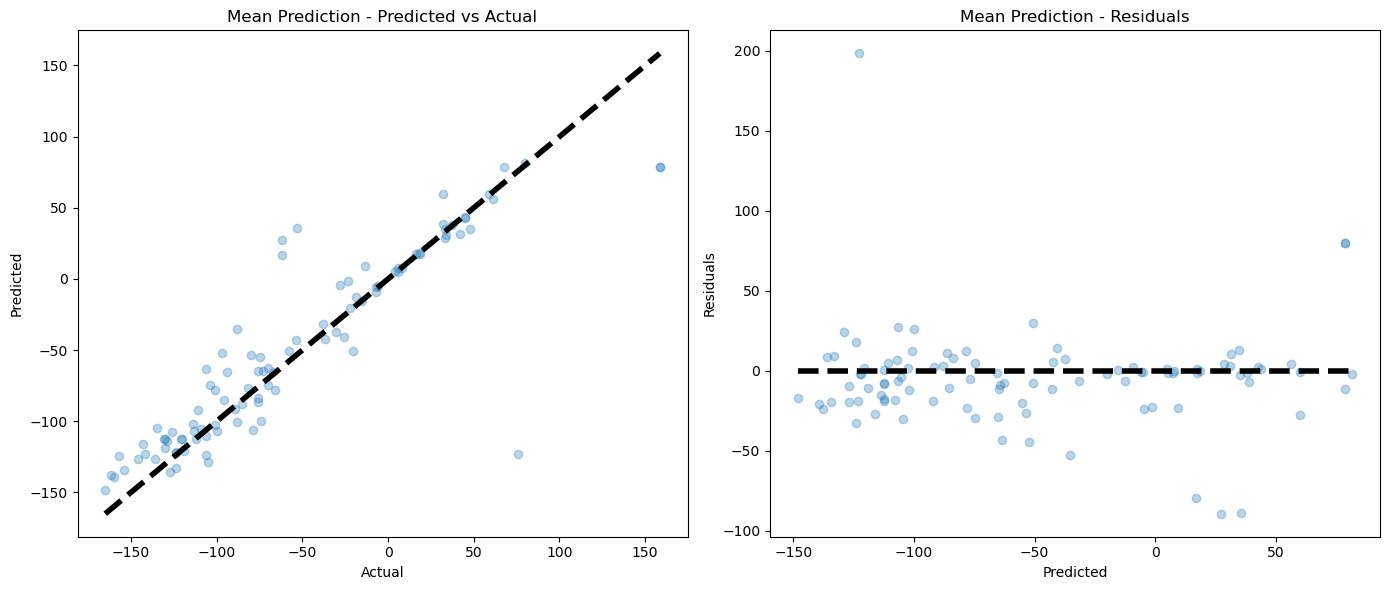

In [58]:
## Trying a multimodel
# Create a model wich take the mean prediction of the 3 models

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Predictions
y_pred_rf = rf_best.predict(X_test_scaled)
y_pred_gb = gb_best.predict(X_test_scaled)
y_pred_lgbm = lgbm_best.predict(X_test_scaled)

# Mean prediction
y_pred_mean = (y_pred_rf + y_pred_gb + y_pred_lgbm) / 3

# Evaluation
mse = mean_squared_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)
print(f"Mean prediction - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_mean, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Mean Prediction - Predicted vs Actual')

# Plotting Residuals
residuals_mean = y_test - y_pred_mean

plt.subplot(1, 2, 2)
plt.scatter(y_pred_mean, residuals_mean, alpha=0.3)
plt.plot([y_pred_mean.min(), y_pred_mean.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Mean Prediction - Residuals')

plt.tight_layout()
plt.show()

## Test the model on another dataset

In [77]:
val_path = Path("/Users/malogfeller/git/Ppchem-MP-predictor/Alcane_analysis/full_validation.csv")
validation = pd.read_csv(val_path)
validation.shape

(152, 1828)

In [78]:
# Rename the SMILES column with smiles
validation = validation.rename(columns={"SMILES": "smiles"})

In [79]:
# Extracting Ave °C from the validation dataset
y_validation = validation["Ave °C"]
X_validation = validation[X.columns]
print(X_validation.shape)
print(X.shape)

(152, 194)
(486, 194)


In [80]:
# Fill NaN values with the mean
X_validation = X_validation.fillna(X_validation.mean())

Mean prediction - MSE: 4069.09, R2: 0.71


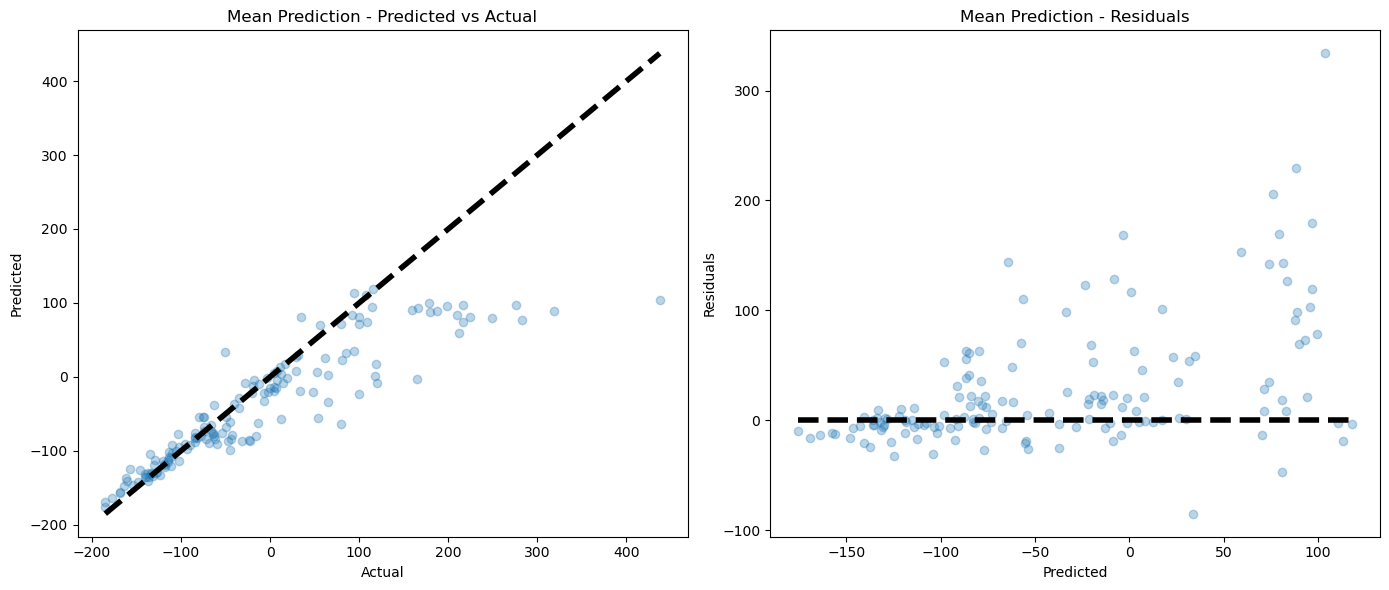

In [81]:
# Standardizing the features
X_validation_scaled = scaler.transform(X_validation)

# Predictions
y_pred_rf = rf_best.predict(X_validation_scaled)
y_pred_gb = gb_best.predict(X_validation_scaled)
y_pred_lgbm = lgbm_best.predict(X_validation_scaled)

# Mean prediction
y_pred_mean = (y_pred_rf + y_pred_gb + y_pred_lgbm) / 3

# Evaluation
mse = mean_squared_error(y_validation, y_pred_mean)
r2 = r2_score(y_validation, y_pred_mean)
print(f"Mean prediction - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_validation, y_pred_mean, alpha=0.3)
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Mean Prediction - Predicted vs Actual')

# Plotting Residuals
residuals_mean = y_validation - y_pred_mean

plt.subplot(1, 2, 2)
plt.scatter(y_pred_mean, residuals_mean, alpha=0.3)
plt.plot([y_pred_mean.min(), y_pred_mean.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Mean Prediction - Residuals')

plt.tight_layout()
plt.show()

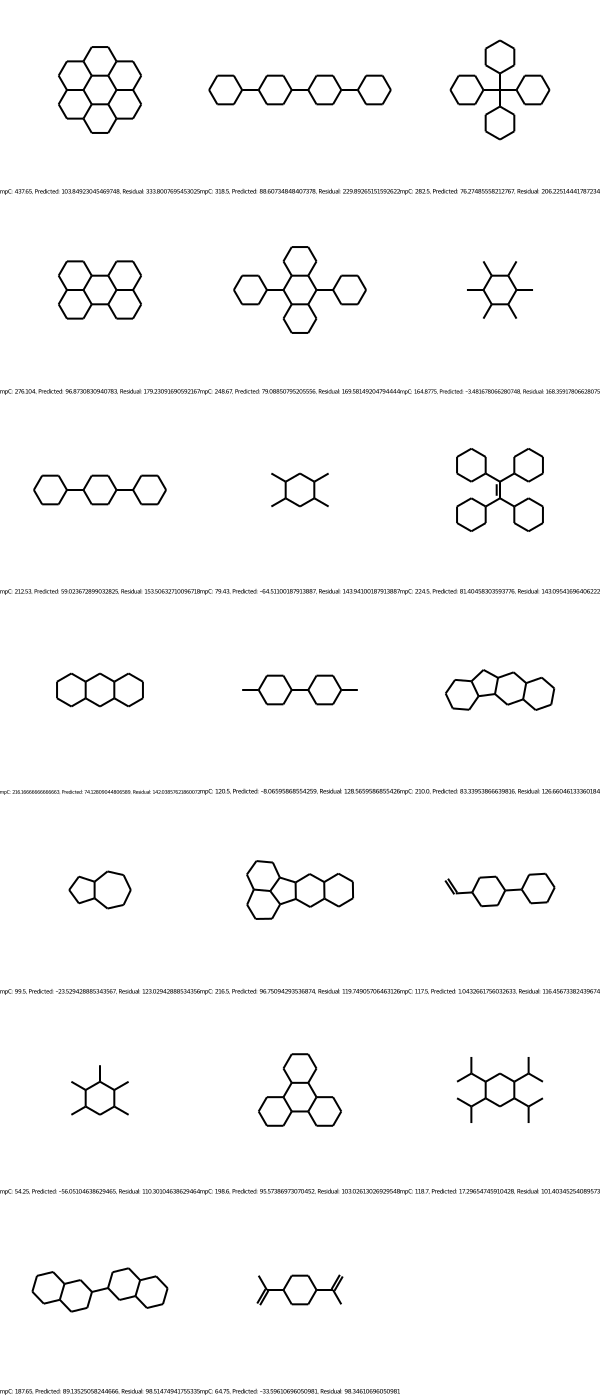

In [83]:
# Display the 20 worst predicted molecules as mol object
worst_predicted = validation.copy()
worst_predicted['predicted'] = y_pred_mean
worst_predicted['residuals'] = residuals_mean
worst_predicted['abs_residuals'] = abs(residuals_mean)
worst_predicted = worst_predicted.sort_values(by='abs_residuals', ascending=False)
worst_predicted = worst_predicted.head(20)

# Generate RDKit Mol objects
mols = [Chem.MolFromSmiles(smiles) for smiles in worst_predicted['smiles']]
legend_texts = [f"mpC: {mp}, Predicted: {pred}, Residual: {res}" for mp, pred, res in zip(worst_predicted['Ave °C'], worst_predicted['predicted'], worst_predicted['residuals'])]

# Draw the molecules in a grid with legend
img = Draw.MolsToGridImage(mols, legends=legend_texts, subImgSize=(200, 200))
display(img)
